# K-Nearest Neighbors Recommendation with Collaborative Filtering

We wanted to apply K-NN algorithm to implement our own recommender system for restaurants. We will be using an intem-based collaborative filtering system, where we use patterns of users who went to the same restaurant to make recommendations. 

For our K-NN Algorithm, we are trying to find our nearest neighbors by distance based off of other users' behavior. If a lot of people visit both Restaurant A and Restaurant B, then the two restaurants are likely to be close neighbors, and we will recommend it to them. 

Recommendation System was inspired by Nick Becker: https://beckernick.github.io/music_recommender/

In [180]:
# imports
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from scipy.sparse import csr_matrix
from fuzzywuzzy import fuzz
import re
import random
import warnings
warnings.filterwarnings('ignore')

We'll be mainly using two data sets, both extracted from Yelp's original dataset `review.json` and `business.json`:
- extracted_restaurants_from_business.csv
- extracted_restaurants_from_review.csv

In [181]:
# Reading in 'extracted_restaurants_from_business.csv'
rest_biz_csvTOpd = pd.read_csv('extracted_restaurants_from_business.csv')

In [182]:
# Business IDs for the restaurants
restaurant_id_list = rest_biz_csvTOpd.business_id.tolist()
restaurant_id_list[:5]

['QXAEGFB4oINsVuTFxEYKFQ',
 'gnKjwL_1w79qoiV3IC_xQQ',
 '1Dfx3zM-rW4n-31KeC8sJg',
 'fweCYi8FmbJXHCqLnwuk8w',
 'PZ-LZzSlhSe9utkQYU8pFg']

In [183]:
print('Number of restaurants in the original dataset:',len(restaurant_id_list))

Number of restaurants in the original dataset: 59371


In [184]:
# Reading in 'extracted_restaurants_from_review.csv'
rest_review_csvTOpd = pd.read_csv('extracted_restaurants_from_review.csv')

In [185]:
# Rename column containing the old indices
rest_review_csvTOpd.rename(columns={"Unnamed: 0": "Index_From_review.JSON"}).head()

,review_id,user_id,business_id,stars,text
0,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."


## Exploratory Data Analysis

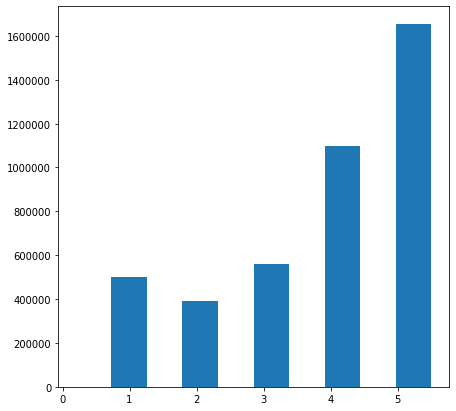

In [186]:
plt.figure(figsize=(7,7))
plt.hist(rest_review_csvTOpd.stars, range = (0.2,5.5), bins = 10)
plt.show()

In [187]:
rest_review_length = len(rest_review_csvTOpd)
print("There are {} restaurant reviews.".format(rest_review_length))
testset = rest_review_csvTOpd[:1000]
category = testset.stars
testset.head()

There are 4201685 restaurant reviews.


,review_id,user_id,business_id,stars,text
0,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."


In [188]:
# restaurant business dataset

rest_biz_csvTOpd.head()

,business_id,name,address,city,state,stars,review_count,is_open,attributes,categories,hours
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
1,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
2,1Dfx3zM-rW4n-31KeC8sJg,Taco Bell,2450 E Indian School Rd,Phoenix,AZ,3.0,18,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Restaurants, Breakfast & Brunch, Mexican, Taco...","{'Monday': '7:0-0:0', 'Tuesday': '7:0-0:0', 'W..."
3,fweCYi8FmbJXHCqLnwuk8w,Marco's Pizza,5981 Andrews Rd,Mentor-on-the-Lake,OH,4.0,16,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Italian, Restaurants, Pizza, Chicken Wings","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ..."
4,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","Restaurants, Italian",NaN


In [189]:
# restaurant reviews dataset

rest_review_csvTOpd.head()

,review_id,user_id,business_id,stars,text
0,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
1,fdiNeiN_hoCxCMy2wTRW9g,w31MKYsNFMrjhWxxAb5wIw,eU_713ec6fTGNO4BegRaww,4.0,I'll be the first to admit that I was not exci...
2,G7XHMxG0bx9oBJNECG4IFg,jlu4CztcSxrKx56ba1a5AQ,3fw2X5bZYeW9xCz_zGhOHg,3.0,Tracy dessert had a big name in Hong Kong and ...
3,8e9HxxLjjqc9ez5ezzN7iQ,d6xvYpyzcfbF_AZ8vMB7QA,zvO-PJCpNk4fgAVUnExYAA,1.0,This place has gone down hill. Clearly they h...
4,kbtscdyz6lvrtGjD1quQTg,FIk4lQQu1eTe2EpzQ4xhBA,8mIrX_LrOnAqWsB5JrOojQ,4.0,"Like walking back in time, every Saturday morn..."


In [190]:
num_users = len(rest_review_csvTOpd['user_id'].unique())
print("number of unique users:", num_users)

num_rest_review = len(rest_review_csvTOpd['business_id'].unique())
print("number of unique restaurants:", num_rest_review)

number of unique users: 1148099
number of unique restaurants: 59372


For the KNN Model for item-based filtering, we will need to set up a matrix with restaurants for rows and users by columns, so we would getting a 11480909 x 59371 matrix. Pandas throws an error because this matrix is too large to process, so we will decide to focus the model on recommending restaurants by location, specifically by state. It makes sense too. No use in providing recommendations that are in another state and too far away. 

Where are most of the restaurants in the dataset located? 

Text(0.5, 1.0, 'No. of unique restaurants by state')

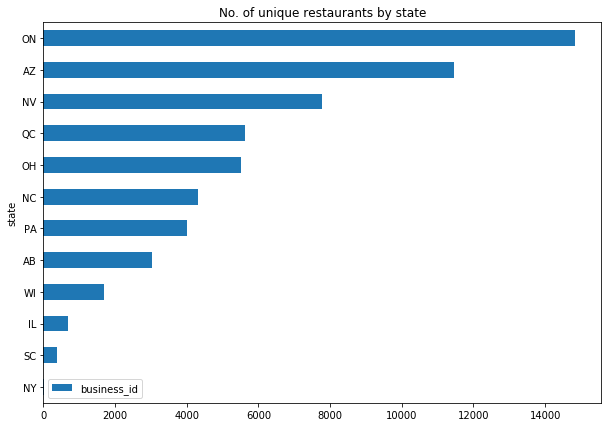

In [191]:
state_count = pd.DataFrame(rest_biz_csvTOpd.groupby('state').count()['business_id'])
state_count = state_count[state_count['business_id'] > 5].sort_values(by='business_id', ascending = True)
state_count.plot.barh(figsize = (10, 7))
plt.title('No. of unique restaurants by state')

We will be processing Yelp's data and split it by state.

In [192]:
# Getting restaurants id per state
on_rest_id = rest_biz_csvTOpd.loc[(rest_biz_csvTOpd['state'] == 'ON') & (rest_biz_csvTOpd['is_open'] == 1)]['business_id']
az_rest_id = rest_biz_csvTOpd.loc[(rest_biz_csvTOpd['state'] == 'AZ') & (rest_biz_csvTOpd['is_open'] == 1)]['business_id']
nv_rest_id = rest_biz_csvTOpd.loc[(rest_biz_csvTOpd['state'] == 'NV') & (rest_biz_csvTOpd['is_open'] == 1)]['business_id']
qc_rest_id = rest_biz_csvTOpd.loc[(rest_biz_csvTOpd['state'] == 'QC') & (rest_biz_csvTOpd['is_open'] == 1)]['business_id']
oh_rest_id = rest_biz_csvTOpd.loc[(rest_biz_csvTOpd['state'] == 'OH') & (rest_biz_csvTOpd['is_open'] == 1)]['business_id']
nc_rest_id = rest_biz_csvTOpd.loc[(rest_biz_csvTOpd['state'] == 'NC') & (rest_biz_csvTOpd['is_open'] == 1)]['business_id']
pa_rest_id = rest_biz_csvTOpd.loc[(rest_biz_csvTOpd['state'] == 'PA') & (rest_biz_csvTOpd['is_open'] == 1)]['business_id']
ab_rest_id = rest_biz_csvTOpd.loc[(rest_biz_csvTOpd['state'] == 'AB') & (rest_biz_csvTOpd['is_open'] == 1)]['business_id']

# Getting data per state
on_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(on_rest_id)]
az_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(az_rest_id)]
nv_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(nv_rest_id)]
qc_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(qc_rest_id)]
oh_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(oh_rest_id)]
nc_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(nc_rest_id)]
pa_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(pa_rest_id)]
ab_reviews = rest_review_csvTOpd[rest_review_csvTOpd['business_id'].isin(ab_rest_id)]


How many restaurants do we have per state in our data?

In [193]:
print(on_reviews.shape[0])
print(az_reviews.shape[0])
print(nv_reviews.shape[0])
print(qc_reviews.shape[0])
print(oh_reviews.shape[0])
print(nc_reviews.shape[0])
print(pa_reviews.shape[0])
print(ab_reviews.shape[0])

474983
1013354
1175316
121365
198821
236604
176969
54216


## Model Building (with Pennsylvania data)

Now that we know what kind of data we are working with, we need to process the data so that it can be put into the KNN model for recommendation. Like mentioned above, we need to convert each state's restaurant data into a no. of restaurants x no. of users sized matrix. KNN algorithm will take the matrix and determines a restaurant's neighbors based off of distance between to other restaurants. 

In [194]:
def KNN_matrix(data):
    """takes in [state]_reviews dataframe and returns a sparse matrix and a list for business_id
    to prepare for KNN model. Beware of long run time"""
    
    matrix = data.pivot_table(index='business_id', columns='user_id', values = 'stars', aggfunc = 'mean').fillna(0)
    sparse_matrix = csr_matrix(matrix)
    
    business_id = list(matrix.index)
    business_names = []
    for i in business_id:
        business_names.append(list(rest_biz_csvTOpd[rest_biz_csvTOpd['business_id'] == i]['name'])[0])
        
    return (sparse_matrix, business_id, business_names)

# using pennsylvania data for now
pa_sparse = KNN_matrix(pa_reviews)


Now that we have the sparse matrix ready, lets fit a KNN model. We decided to use cosine similiarity as opposed to other distance metrics like Euclidean distance, because cosine similarities looks at the angle between two vectors. In our case, it means that though in aggregate, two restaurants may have very different people visit and hence the euclidean distance would be long, the angle between the vectors might be small, hence they can be more similar. Image below shows that while "d" which is euclidean distance can increase as one vector is longer than another, the angle between both vectors reamin constant. That's the similarity we care about.


<img src='cosine_vs_euclidean.png' width = 700>

In [195]:
knn_model_pa = NearestNeighbors(metric='cosine')
knn_model_pa.fit(pa_sparse[0])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [196]:
def restaurant_recommender(model, sparse_matrix, n_recommendations = 5, fav_restaurant = ''):
    """takes in knn_model, a sparse matrix processed by KNN_matrix, and fav_restaurant which is restaurant on 
    which model makes recommendation. fav_restaurant does a fuzzy match(based on Levenshtein Distance) 
    in case restaurants are not typed in perfectly"""
    
    # unwraps sparse_matrix into its components
    matrix, business_id, business_names = sparse_matrix[0], sparse_matrix[1], sparse_matrix[2]
    
    if fav_restaurant == '':
        fav_restaurant = random.choice(business_names)
    
    # if fav_restaurant is not spelled perfectly, need to do a fuzzy match
    possible_matches = []
    match_scores = []
    for business in business_names:
        ratio = fuzz.ratio(business.lower(), fav_restaurant.lower())
        if ratio >= 50:
            possible_matches.append(business)
            match_scores.append(ratio)
    
    # now that we have a fav_restaurant that matches our database, lets recommend some restaurants.
    try:
        fav_restaurant = possible_matches[match_scores.index(max(match_scores))]
        fav_restaurant_index = business_names.index(fav_restaurant)
        distances, indices = model.kneighbors(matrix[fav_restaurant_index], n_neighbors = n_recommendations+1)
        
        for i, rest_id in enumerate(indices[0]):
            if i == 0:
                print(fav_restaurant, '\n')
                print('Here are some other restaurants that people visited that you might like: \n')
            else:
                rest_recommend = business_names[rest_id]
                print(i,'. ', rest_recommend)
    except:
        return "Oops, restaurant not in database"


Model building is complete! Enter a restaurant below and get some recommendations for restaurants in Pennsylvania! If you don't put in a restaurant, model will select a restaurant at random. 

In [197]:
# run this cell to input a restaurant and get some recommendations
# just hit enter if you don't have a favorite restaurant and just want to see recommendations

fav_restaurant=input("Enter a restaurant: ")
restaurant_recommender(knn_model_pa, pa_sparse, 5, fav_restaurant)

Enter a restaurant: 
The Baltimore House 

Here are some other restaurants that people visited that you might like: 

1 .  Tavern In The Hills
2 .  Eggheads
3 .  Steak ’n Shake
4 .  Arby's
5 .  Classic Chinese Cuisine


Great! Our recommendation system makes solid recommendations for the most part. Recommendation was based on what other restaurants people visited who also visited this particular restaurant. There are many limitations to this algorithm, as I will later discuss, but lets look at recommendations for other states.

## Alabama Recommendations

In [198]:
# processing data for model
ab_sparse = KNN_matrix(ab_reviews)

# fitting model
knn_model_ab = NearestNeighbors(metric='cosine')
knn_model_ab.fit(ab_sparse[0])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [199]:
# recommendations for Alabama
fav_restaurant=input("Enter a restaurant: ")
restaurant_recommender(knn_model_ab, ab_sparse)

Enter a restaurant: 
Italian Kitchen 

Here are some other restaurants that people visited that you might like: 

1 .  Simple Simon Pies
2 .  Little Caesars Pizza
3 .  Roxy's Burger Bar
4 .  Safeway Food & Drug
5 .  The Chopped Leaf


## Quebec Recommendations


In [200]:
# processing data for model
qc_sparse = KNN_matrix(qc_reviews)

# fitting model
knn_model_qc = NearestNeighbors(metric='cosine')
knn_model_qc.fit(qc_sparse[0])

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [201]:
# recommendations for Quebec
fav_restaurant=input("Enter a restaurant: ")
restaurant_recommender(knn_model_qc, qc_sparse)

Enter a restaurant: 
Casa Vinho 

Here are some other restaurants that people visited that you might like: 

1 .  Le Bordelais
2 .  Aldea
3 .  Skippers
4 .  Zoe's Food Truck
5 .  Amici


## Limitations of the Model


### Scalability
Unfortunately, larger data sets such as Arizona's dataset throws an error that the dataframe is too big. We need to find out a way to partition the large datasets in a way that makes sense for the recommendation. Some possible options:

- partition data by location (zip_code, latitude/longitude)
- partition data by restaurant type
- partition data by clusters from K-means algorithm
- partition data randomly

Out of these options, partitioning further by location would be ideal, either by groups defined by latitude and longitude or by zip code. Can further explore into using Google Maps API to get this data, but regardless of how we partition the data we will still be applying the model built above. 

### Limited Features
The only thing that KNN model makes recommendations on is what other people who also visited the same restaurant went to. With the KNN model, we're unable to add more features such as location, restaurant type, price range of restaurants, etc, and assign weights to them. That means that we cannot personalize recommendations based on those features at all. The neighbors algorithm takes some of those features into consideration, but only by the nature of recommending other restaurants that people liked, not because we programmed the model to include those features. 

Some examples of problems that limited features propose:
- if people go to a restaurant and go to dessert place after, model will recommend the dessert place, even if user is looking for a restaurant that is similar.
- if people love a restaurant chain such as Mcdonalds, model will recommend other mcdonalds, but not what user might be looking for. 
- though the neighbors algorithm accounts for this, model could recommend a restaurant far away, simply because others went there as well. 

### Only popular restaurants
Model doesn't know how to recommend restaurants that are less popular, because by design of model it only recommends restaurants that others go to (definition of popular) who also visited input restaurant. While you can't go wrong with recommending popular restaurants, really great recommendation systems can reveal hidden gems and fit your unique interests. 

## Conclusion

Despite limitations of the model, we can see that the KNN algorithm can still make some solid predictions by using collaborative filtering! 

